<a href="https://colab.research.google.com/github/ChiriKamau/notebooks/blob/main/round_edge_detection_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Start Karitho

# Edge Detection and Bounding Box Extraction  
### A Step-by-Step Study Based on Gonzalez & Woods (2002)

A structured approach to detecting object edges and drawing a bounding box using classical digital image processing techniques. from:

Gonzalez, R. C., & Woods, R. E. (2002). *Digital Image Processing* (2nd ed.). Prentice Hall.



## What I am doing


- Trying to understand what an edge is in the context of digital images
- Learn why edge detection is based on image derivatives
- Apply edge detection as a foundation for object localization
- Use detected edges to compute a bounding box around an object


## Digital Image Representation

 A digital image can be modeled as a two-dimensional function:

f(x, y) = i(x, y) · r(x, y)

where:
- i(x, y) represents illumination
- r(x, y) represents reflectance

In most image processing tasks, including edge detection, we are primarily interested in the reflectance component, as it carries information about object structure and boundaries.
The researn we focuse on reflectance is it gives us the nucessary information to perfom edge detection.

Example: White has a high reflectance and black has a low reflectance by knowing this we can detect the edegs in a image where the background is black and object is white.


(np.float64(-0.5), np.float64(1279.5), np.float64(719.5), np.float64(-0.5))

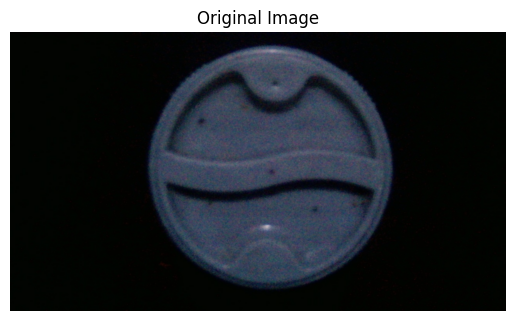

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

# Raw GitHub image URL
image_url = "https://raw.githubusercontent.com/ChiriKamau/notebooks/main/round_object.jpg"

# Read image from URL
image_data = cv2.imdecode(
    np.asarray(bytearray(__import__("urllib").request.urlopen(image_url).read()), dtype=np.uint8),
    cv2.IMREAD_COLOR
)

# Convert BGR → RGB for correct display
image_rgb = cv2.cvtColor(image_data, cv2.COLOR_BGR2RGB)

plt.imshow(image_rgb)
plt.title("Original Image")
plt.axis("off")

## Conversion to Grayscale

Edge detection relies on detecting abrupt changes in intensity.  
Color images consist of three channels (RGB), but edge operators are defined for scalar-valued functions.

By converting the image to grayscale, we reduce the image to a single intensity function:

f(x, y) ∈ [0, L − 1]

This simplifies analysis and ensures that edge detection is based solely on intensity discontinuities rather than color variations.

###Why not use a colored image:

RGB Channels Can Produce Conflicting Edges

In a color image:

An edge may appear strongly in the red channel, Weakly in green, Not at all in blue

If edge detection is applied separately to each channel:
You get multiple inconsistent edge maps

Combining them becomes non-trivial and error-prone

###Grayscale conversion:

Fuses color information into a single, perceptually meaningful intensity Produces a consistent and stable edge response


(np.float64(-0.5), np.float64(1279.5), np.float64(719.5), np.float64(-0.5))

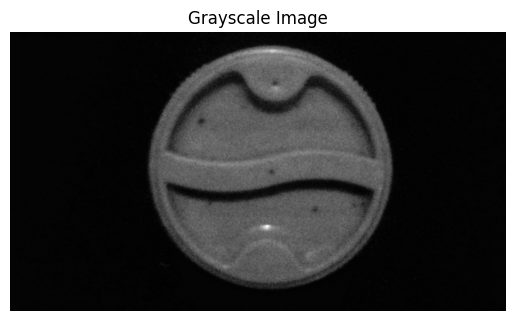

In [2]:
gray = cv2.cvtColor(image_data, cv2.COLOR_BGR2GRAY)

plt.imshow(gray, cmap="gray")
plt.title("Grayscale Image")
plt.axis("off")


## Noise Reduction Before Edge Detection

Differentiation amplifies high-frequency components in an image.  
Unfortunately, noise is also a high-frequency component.

Gonzalez & Woods emphasize that smoothing must be applied before edge detection to reduce the effect of noise and prevent false edges.

We use Gaussian smoothing, which performs weighted averaging and preserves large-scale structures while suppressing small fluctuations.


## Gaussian Smoothing

The Gaussian filter is defined as:

G(x, y) = (1 / 2πσ²) · exp(−(x² + y²) / 2σ²)

Convolving the image with this function produces a smoothed version of the image.  
The parameter σ controls the degree of smoothing: higher values result in stronger noise suppression but reduced edge sharpness.


(np.float64(-0.5), np.float64(1279.5), np.float64(719.5), np.float64(-0.5))

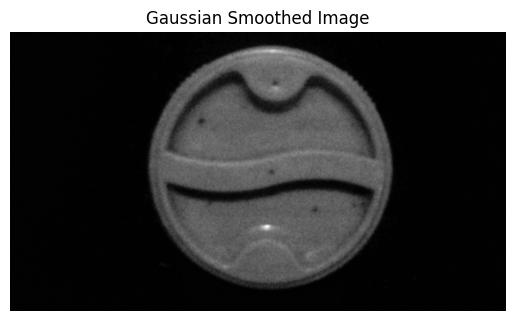

In [3]:
blur = cv2.GaussianBlur(gray, (5, 5), 1.0)

plt.imshow(blur, cmap="gray")
plt.title("Gaussian Smoothed Image")
plt.axis("off")


## Definition of an Edge

An edge is defined as a set of pixels where the image intensity changes abruptly.

Mathematically, edges correspond to points where the first derivative of the image intensity function has a large magnitude.

This makes image gradients the fundamental tool for edge detection.


## First-Order Derivative and the Image Gradient

The gradient of an image f(x, y) is defined as:

∇f = [ ∂f/∂x , ∂f/∂y ]

The gradient magnitude is given by:

|∇f| = √( (∂f/∂x)² + (∂f/∂y)² )

Large gradient magnitudes indicate the presence of edges.


(np.float64(-0.5), np.float64(1279.5), np.float64(719.5), np.float64(-0.5))

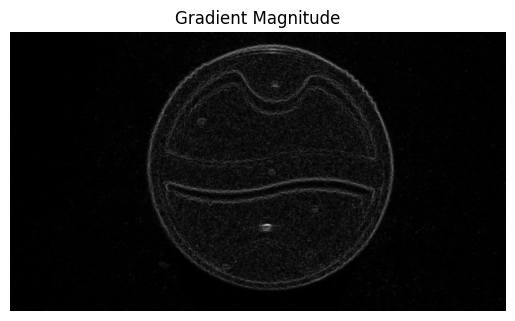

In [4]:
gx = cv2.Sobel(blur, cv2.CV_64F, 1, 0, ksize=3)
gy = cv2.Sobel(blur, cv2.CV_64F, 0, 1, ksize=3)

gradient_magnitude = cv2.magnitude(gx, gy)
gradient_magnitude = cv2.convertScaleAbs(gradient_magnitude)

plt.imshow(gradient_magnitude, cmap="gray")
plt.title("Gradient Magnitude")
plt.axis("off")


## Thresholding and Edge Map Formation

After computing the gradient magnitude, we must decide which pixels correspond to true edges.

This is done using thresholding:

g(x, y) = 1  if |∇f(x, y)| ≥ T  
g(x, y) = 0  otherwise

The result is a binary image known as an edge map, which highlights significant intensity transitions.


(np.float64(-0.5), np.float64(1279.5), np.float64(719.5), np.float64(-0.5))

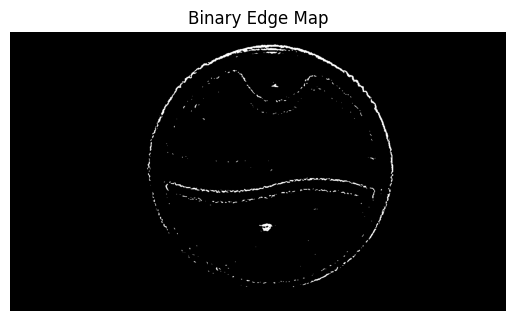

In [5]:
_, edges = cv2.threshold(gradient_magnitude, 50, 255, cv2.THRESH_BINARY)

plt.imshow(edges, cmap="gray")
plt.title("Binary Edge Map")
plt.axis("off")


## Morphological Processing for Edge Linking

Detected edges are often broken or discontinuous due to noise, illumination variation, or threshold selection.

Morphological operations, particularly dilation, are used to:
- Connect nearby edge segments
- Close small gaps
- Improve boundary continuity

This step is essential before extracting object boundaries.


(np.float64(-0.5), np.float64(1279.5), np.float64(719.5), np.float64(-0.5))

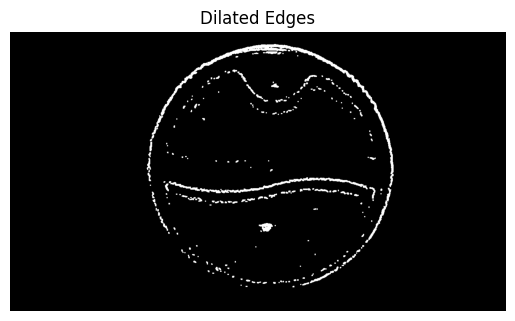

In [6]:
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
edges_dilated = cv2.dilate(edges, kernel, iterations=1)

plt.imshow(edges_dilated, cmap="gray")
plt.title("Dilated Edges")
plt.axis("off")


## Morphological Closing and Region Segmentation

At this step, we convert the edge map into a **filled segmented region**:

1. **Morphological closing** is applied to the edges:
   - Dilation fills small gaps in the edges.
   - Erosion restores edge thickness.
   - This ensures the object boundaries are **closed**, which is necessary for filling.

2. **Contours** are extracted from the closed edge map:
   - `cv2.findContours` identifies the boundaries of each connected region.

3. **Region filling**:
   - `cv2.drawContours` with `thickness=cv2.FILLED` fills the contours to create a **binary segmentation mask**.
   - White pixels (255) represent the object.
   - Black pixels (0) represent the background.

This produces a **pixel-accurate segmented object** that can be used for measurements like area and dimensions.


In [7]:
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
edges_closed = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel)


In [8]:
edges_dilated = cv2.dilate(edges, kernel, iterations=1)
edges_closed = cv2.erode(edges_dilated, kernel, iterations=1)


In [9]:
contours, _ = cv2.findContours(
    edges_closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
)

segmentation = np.zeros_like(edges_closed)

cv2.drawContours(
    segmentation,
    contours,
    contourIdx=-1,
    color=255,
    thickness=cv2.FILLED
)


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

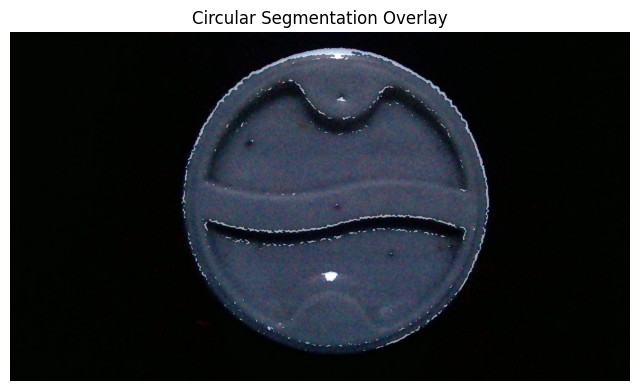

In [16]:
# Create a colored overlay to highlight the segmented region
overlay = image_rgb.copy()

# Make a mask with 3 channels
segmentation_color = cv2.merge([segmentation, segmentation, segmentation])

# Apply the mask as a semi-transparent overlay
alpha = 0.5  # transparency factor
overlay = cv2.addWeighted(overlay, 1.0, segmentation_color, alpha, 0)

# Display the overlay
plt.figure(figsize=(8, 6))
plt.imshow(overlay)
plt.title("Circular Segmentation Overlay")
plt.axis("off")
plt.show()


Segmented circular area: 11209 pixels
Segmented circular area: 3.92 cm²


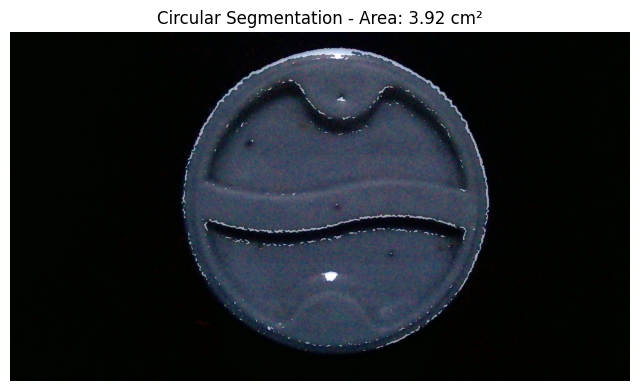

In [17]:
# --- Compute area in pixels ---
area_pixels = cv2.countNonZero(segmentation)
print(f"Segmented circular area: {area_pixels} pixels")

# --- Convert to cm² ---
# Using your scale: 10 cm = 535 pixels
cm_per_pixel = 10 / 535
area_cm2 = area_pixels * (cm_per_pixel ** 2)

print(f"Segmented circular area: {area_cm2:.2f} cm²")

# --- Optional visualization ---
output_area = image_rgb.copy()

# Create a semi-transparent overlay for the segmented region
segmentation_color = cv2.merge([segmentation, segmentation, segmentation])
alpha = 0.5
output_area = cv2.addWeighted(output_area, 1.0, segmentation_color, alpha, 0)

# Display the overlay with area info
plt.figure(figsize=(8,6))
plt.imshow(output_area)
plt.title(f"Circular Segmentation - Area: {area_cm2:.2f} cm²")
plt.axis("off")
plt.show()


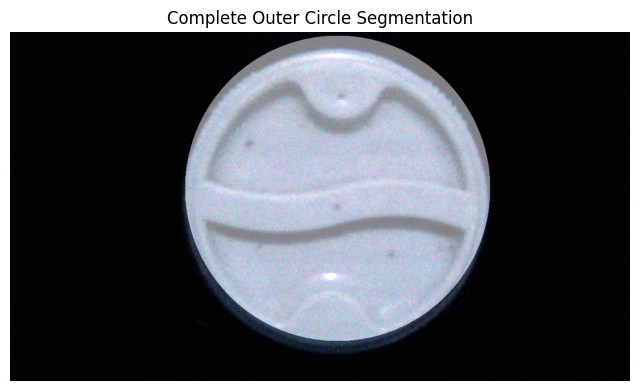

In [20]:
# Find contours in the closed edge image
contours, _ = cv2.findContours(
    edges_closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
)

# Sort contours by area (largest first)
contours = sorted(contours, key=cv2.contourArea, reverse=True)
largest_contour = contours[0]

# Fit a minimum enclosing circle
(x_center, y_center), radius = cv2.minEnclosingCircle(largest_contour)

# Create a blank mask
segmentation_outer_circle = np.zeros_like(edges_closed)

# Draw a filled circle
cv2.circle(
    segmentation_outer_circle,
    center=(int(x_center), int(y_center)),
    radius=int(radius),
    color=255,
    thickness=-1  # filled
)

# Visualize
overlay = image_rgb.copy()
segmentation_color = cv2.merge([segmentation_outer_circle]*3)
overlay = cv2.addWeighted(overlay, 1.0, segmentation_color, 0.5, 0)

plt.figure(figsize=(8,6))
plt.imshow(overlay)
plt.title("Complete Outer Circle Segmentation")
plt.axis("off")
plt.show()
